### The Impulse Response and Convolution

In this notebook, we will make a crude impulse response measurement and use it to do a convolution.

In [2]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook

### A crude impulse response measurement

Let's take the room that we are in as an example of a system. We can imagine an input signal to tbe the speech that you produce and the output signal to be the resulting sound at any point within the room, including that of your own ears. In between the input and output, we essentially have the room itself which acts as a system. Hence your voice will be modified or filtered by the room before it arrives to any point within the room. It is the acoustic properties of the room (such as how absorptive/reflective materials are in the room) that determine the impulse response of the classroom system. You can think of how other rooms affect any input sound - a church, a concert hall, etc. All of these systems can be quantitatively described by their acoustic impulse responses, which is in fact one of the most important pieces of information for doing audio signal processing in general. 

So let's attempt to make a crude measurement of the impulse response of the room that we are in. We can approximate an impulse signal by one which has a high amplitude and short duration. This is why you may sometimes see people clapping inside rooms to get an idea of their impulse response. But let's do something a bit more fun. We can pop a balloon to generate our impulse! Let's try that and see if we can sufficiently excite the room. What is the resulting system order?

In [3]:
# Recording the impulse response - pop the balloon or clap your hand immediately after running this cell.
duration = 6  # seconds
fs = 8000    # Sampling frequency (Hz)
print ('recording...')
IR = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')



recording...
finished recording


Data shape:  (48000, 1)
Recorded Signal:


<IPython.core.display.Javascript object>


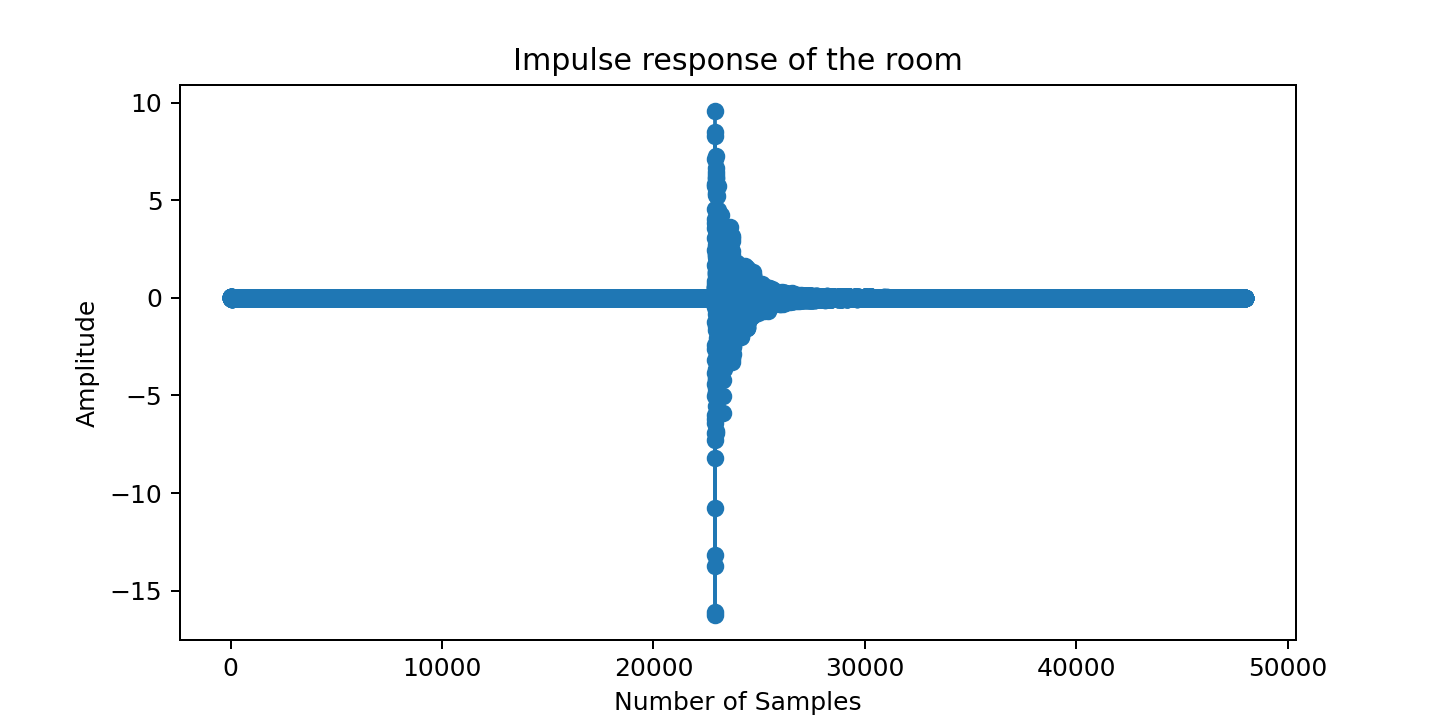

Text(0, 0.5, 'Amplitude')

In [15]:
print("Data shape: ", IR.shape)
print("Recorded Signal:")
IPython.display.display(Audio(IR.T, rate=fs))

fig, axes = plt.subplots(figsize=(8, 4)) 

# axes.plot(IR)
axes.stem(IR,basefmt=" ")
axes.set_title('Impulse response of the room')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')


Okay great, now that we have our crude impulse response of the room, we can proceed to do a **convolution** with another signal. Let's reflect for a moment on this. The impulse response we measured was between 2 physical locations, i.e. from the point where the balloon was popped to the point of the microphone on the computer. This does not mean that this one impulse response has characterised the entire room, but only the transfer function between these two positions. In fact if we were to make the measurement for any other two locations in the room, the impulse response that we obtain would be different, and this is one of the reasons why acoustic signal processing can be quite challenging. At any rate, what we essentially have is an impulse response for two specific locations, so if we wanted to simulate how an input audio signal (speech or music signal for instance) would sound at the point of the microphone when generated from the location of the balloon pop, all we need to do now is a convolution between our input audio signal and the impulse response.

There is another subtle detail worth highlighting here, but one that we will not pay too much attention to for now. The impulse response that we have measured here includes effects from not only the  room, but also the microphone and the data acquisition system within the laptop. Hence we can think of the system as being two blocks, one which is the room and the other the microphone and data acquisition system. If the frequency response of the microphone and data acquisition system is flat, i.e. equal at all frequencies, then we can safely ignore them.

But let's do the convolution and see how things sound!


The sampling frequency of the speech signal is 8000 Hz


<IPython.core.display.Javascript object>


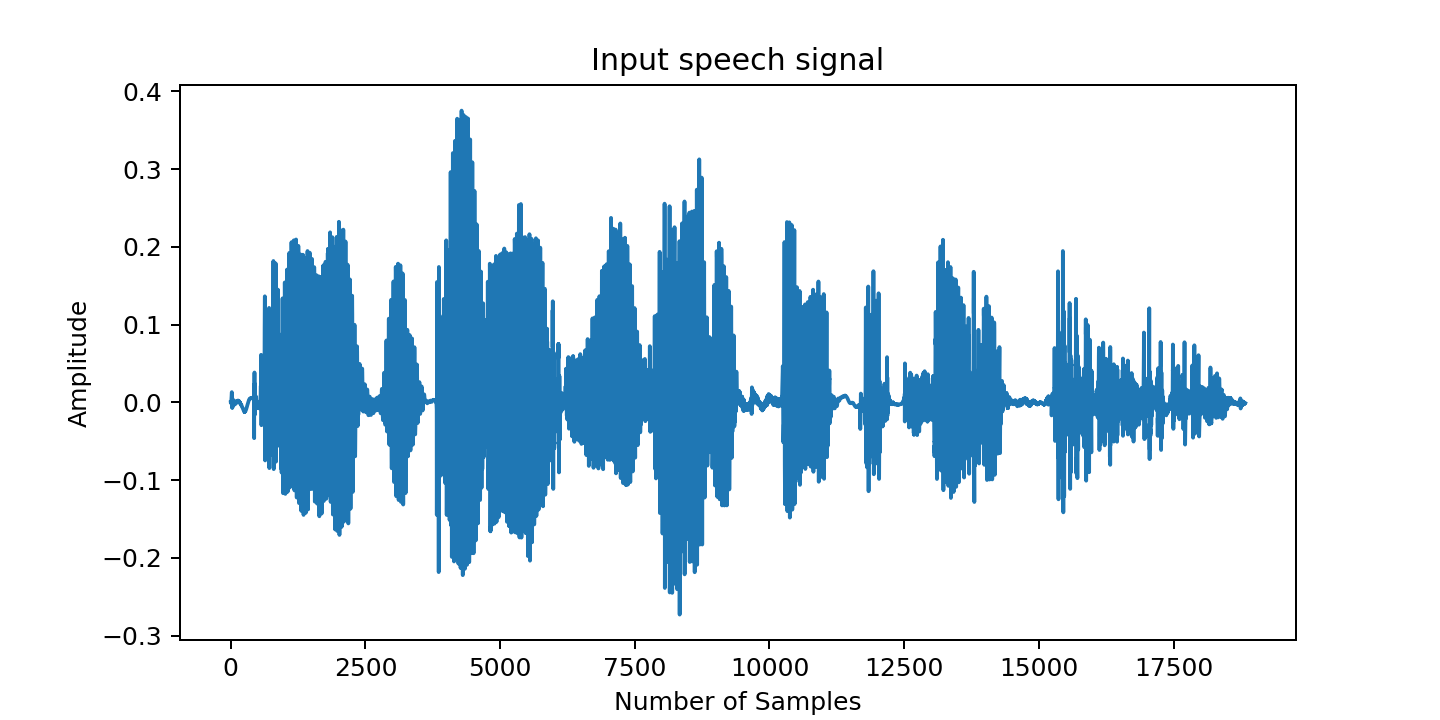

Text(0, 0.5, 'Amplitude')

In [16]:
# Read in a speech signal - use the soundfile package for this

speech, fs = sf.read('speech_signal.wav')
print('The sampling frequency of the speech signal is ' + str(fs)+' Hz')

IPython.display.display(Audio(speech.T, rate=fs))

fig, axes = plt.subplots(figsize=(8, 4)) 

axes.plot(speech)
axes.set_title('Input speech signal')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')



Okay we have our speech signal. We will do the convolution by setting up a convolution matrix and doing a matrix-vector product to obtain the convolved signal. You can already see that this is pretty slow and inefficient by observing the sparsity of the convolution matirx (i.e. large number of zero elements). 

<IPython.core.display.Javascript object>


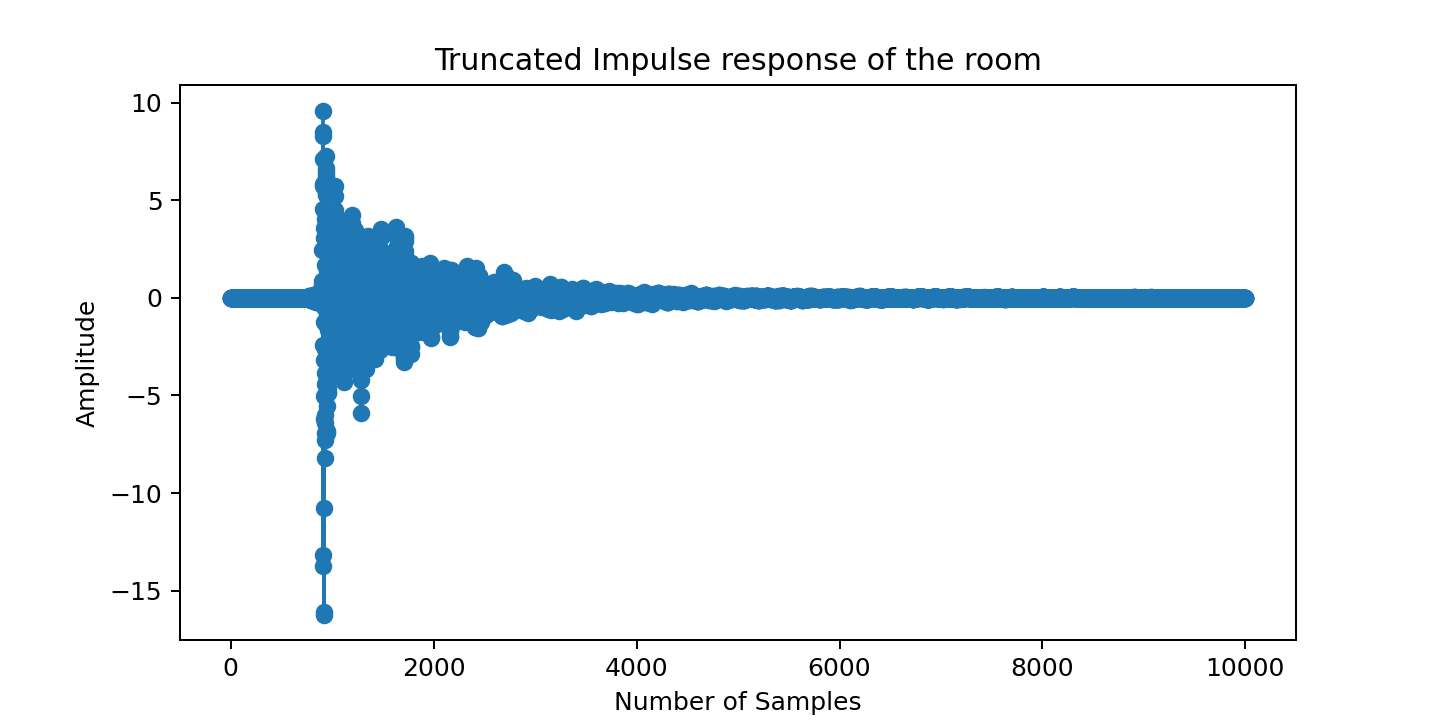

System Order, M = 9999
Length of impulse response, M+1 = 10000
Length of speech signal, L = 18833


<IPython.core.display.Javascript object>


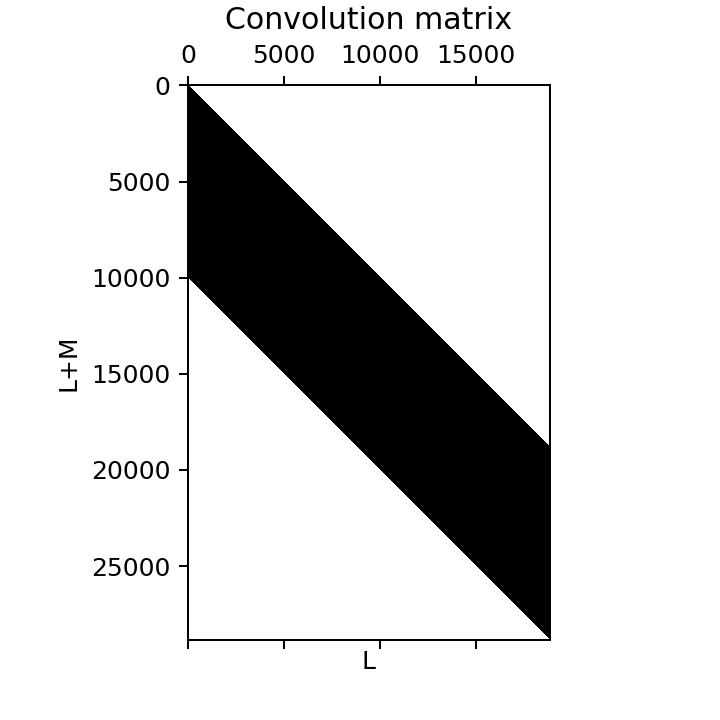

<IPython.core.display.Javascript object>


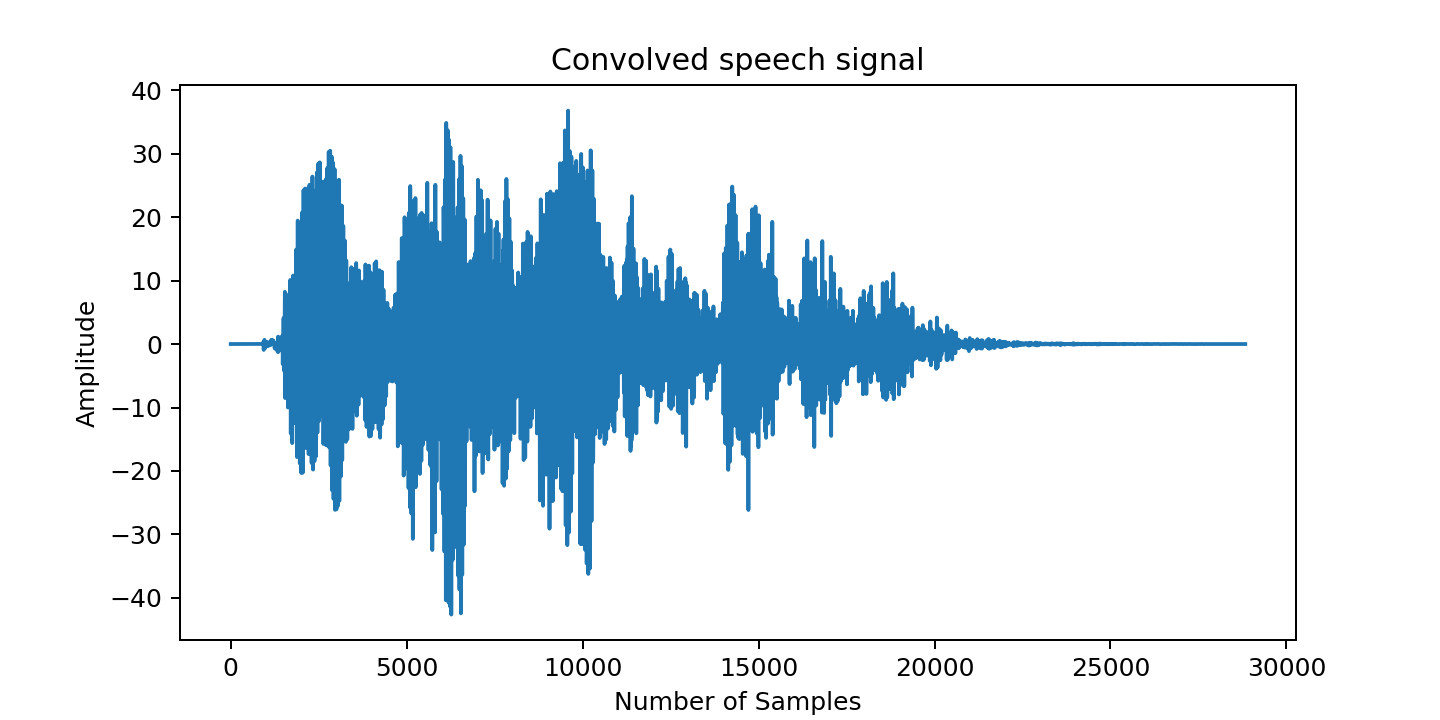

Text(0, 0.5, 'Amplitude')

In [17]:
# Truncate the IR (to remove initial delay and so this does not take forever...)
h = IR[22000:32000,0]

IPython.display.display(Audio(h.T, rate=fs))
fig, axes = plt.subplots(figsize=(8, 4)) 
axes.stem(h,basefmt=" ")
axes.set_title('Truncated Impulse response of the room')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')

M = len(h)-1
L = len(speech)
print('System Order, M = ' + str(M))
print('Length of impulse response, M+1 = ' + str(M+1))
print('Length of speech signal, L = ' +str(L))

# Create the convolution matrix
# Do this by creating a toeplitz matrix 

row1 = np.r_[h[0], np.zeros(L-1)]  # first row in toeplitz matrix
col1 = np.r_[h,np.zeros(L-1)] # first column in toeplitz matrix
H = sp.linalg.toeplitz(col1, row1)  # Toeplitz matrix

fig, axes = plt.subplots(figsize=(4, 4)) 

axes.spy(H) # spy plots a sparse matrix - dark colours when there is data, white when none.
axes.set_title('Convolution matrix')
axes.set_xlabel('L')
axes.set_ylabel('L+M')

# Now we can do the matrix multiplication for the convolution

speech_conv = H@speech

IPython.display.display(Audio(speech_conv.T, rate=fs))

fig, axes = plt.subplots(figsize=(8, 4)) 

axes.plot(speech_conv)
axes.set_title('Convolved speech signal')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')


The convolved speech signal clearly sounds much different than the original signal! We have essentially captured a some sense of how the room 'sounds' as we can convolve any other input signal with our measured impulse response to have an impression of what that signal might sound like within the room.  

### Discrete/Fast Fourier Transform (DFT/FFT)

As you have seen the Fast Fourier Transform (FFT) is a fast way of implementing a Discrete Fourier Transform (DFT). In Python and many other programming languages, there are pre-defined packages which compute the FFT/DFT. In Python, the FFT is done in the numpy package. 

Let's have a look at the FFT of our impulse response (IR), i.e. the frequency response of our system.
Recall our discrete-time domain signal was sampled at sampling frequency, $f_{s} =  8 $ kHz. 
Let us denote the total number of samples in the IR as $N$.

The first step below is to take the FFT of the IR. Recall that this FFT is going to give us both real and imaginary values, which means that we can plot both the magnitude and phase of the signal. The FFT function returns a vector of complex values, however, we need to know what frequency each of these values correspond to. In other words, we need to set up the corresponding frequency vector. This can be done using the python function np.fft.fftfreq, but we will make it ourselves so that we have a better understanding. The frequency bin spacing, $df$ between the samples is given by:

\begin{equation}
df = \frac{f_{s}}{N}
\end{equation}

This equation tells us that we can essentially increase our frequency resolution by including more points or by reducing the sampling frequency. This does not come without consequences however. When increasing the number of points, it means that we lose some temporal resolution of the signal (as we will see a bit later). If we alternatively reduce the sampling frequency, although we increase the resolution, we will reduce the maximum frequency up to which we have information (recall the nyquist-shannon sampling theorem from Lec. 2!).

Using this frequency bin spacing we can then make a vector starting from DC (0 Hz) to $f_{s}-df$. This will however include the double sided spectrum. In many practical cases, we may however only be interested in the single-sided spectrum, which goes up to $f_{s}/2$. 

More info. on the numpy fft routines are given here:
https://numpy.org/doc/stable/reference/routines.fft.html





7001
7001


<IPython.core.display.Javascript object>


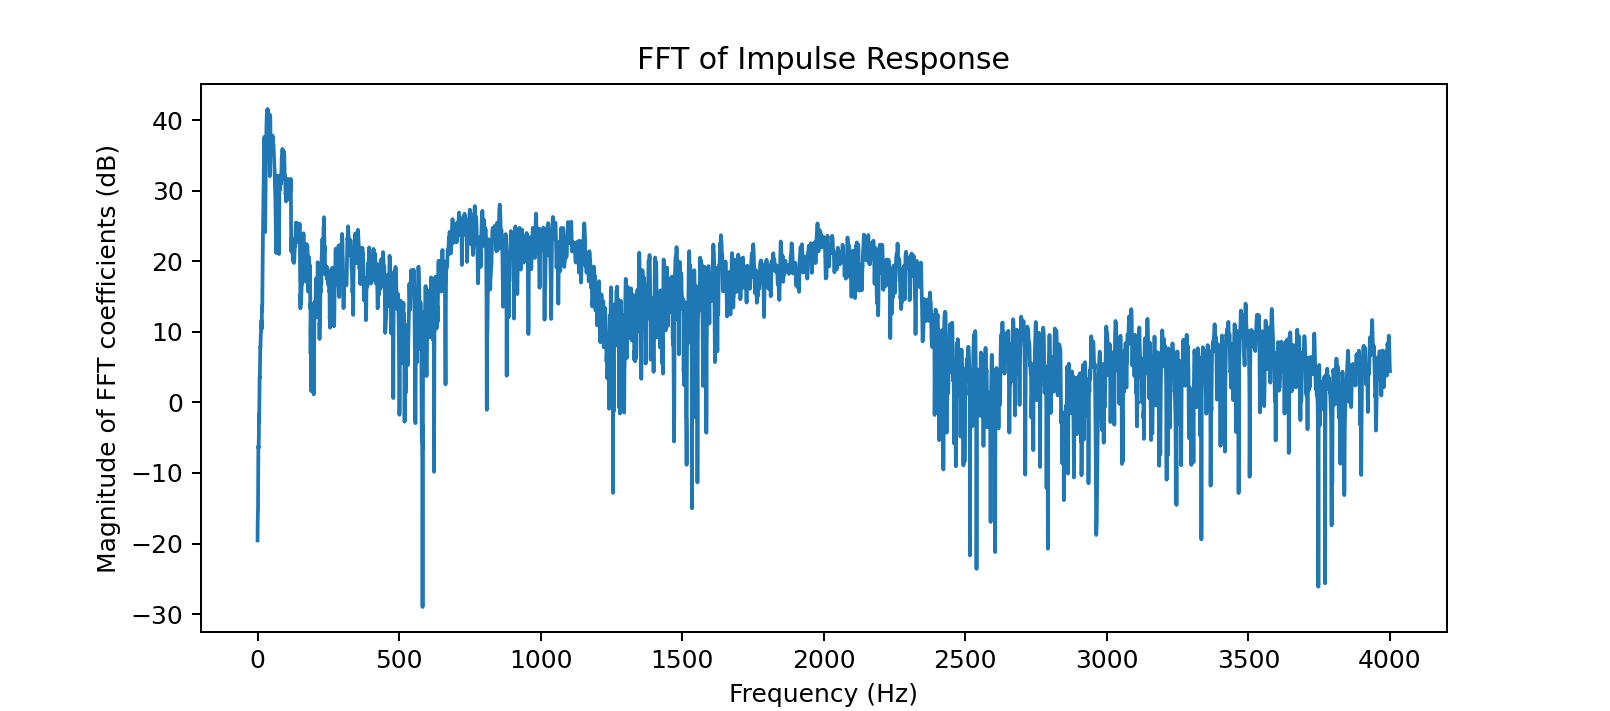

Text(0, 0.5, 'Magnitude of FFT coefficients (dB)')

In [10]:
N = len(h)
Hf = np.fft.fft(h,axis=0)  
Hfss = Hf[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

#Set up the frequency vector
df = fs/N  # the frequency bin spacing
freqs = np.arange(0,fs/2 + df,df) # first value = DC, last value = fs/2

# print (len(Hfss))
# print(len(freqs))
# Let us plot the Magnitude-Squared

fig, axes = plt.subplots(figsize=(4, 2)) 
axes.plot(freqs[0:N//2+1],10*np.log10(np.abs(Hfss**2)))
# axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_title('FFT of Impulse Response')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude of FFT coefficients (dB)')



#### Some more FFT

Let's record some audio instead and look at the FFT. 
How about we do some singing? Let's say a sustained "ooohhh".


In [11]:
# Recording the impulse response - pop the balloon or clap your hand immediately after running this cell.
duration = 3  # seconds
fs = 16000    # Sampling frequency (Hz)
print ('recording...')
yy = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')



recording...
finished recording


<IPython.core.display.Javascript object>


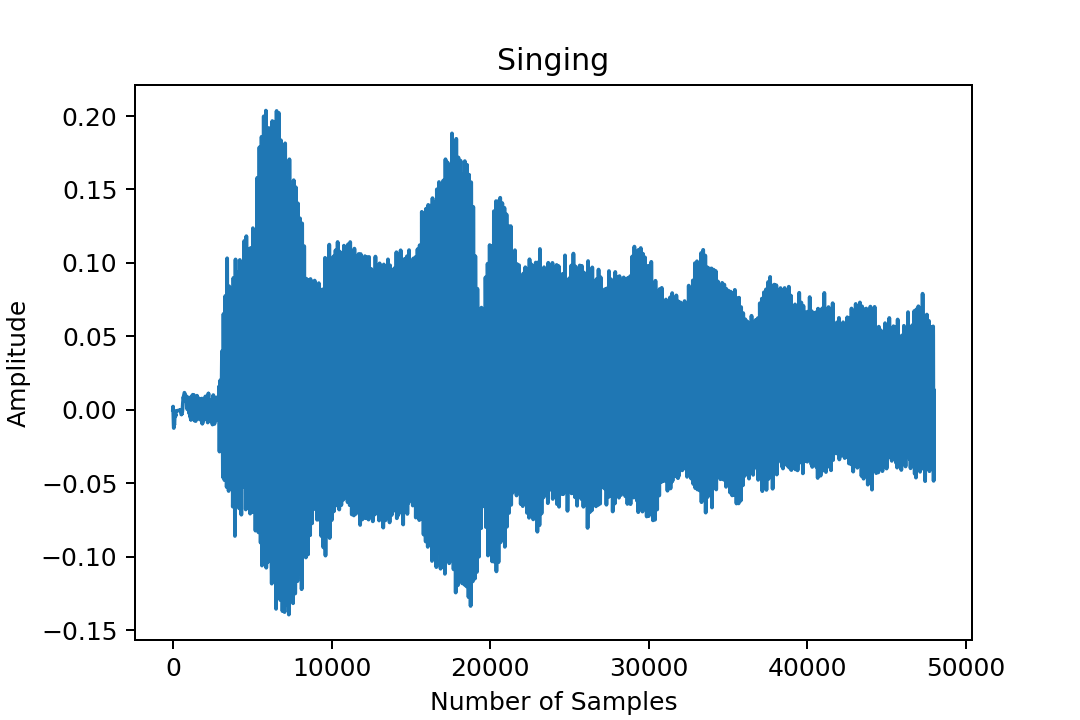

Text(0, 0.5, 'Amplitude')

In [12]:
IPython.display.display(Audio(yy.T, rate=fs))

fig, axes = plt.subplots(figsize=(6, 4)) 

axes.plot(yy)
axes.set_title('Singing')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')


<IPython.core.display.Javascript object>


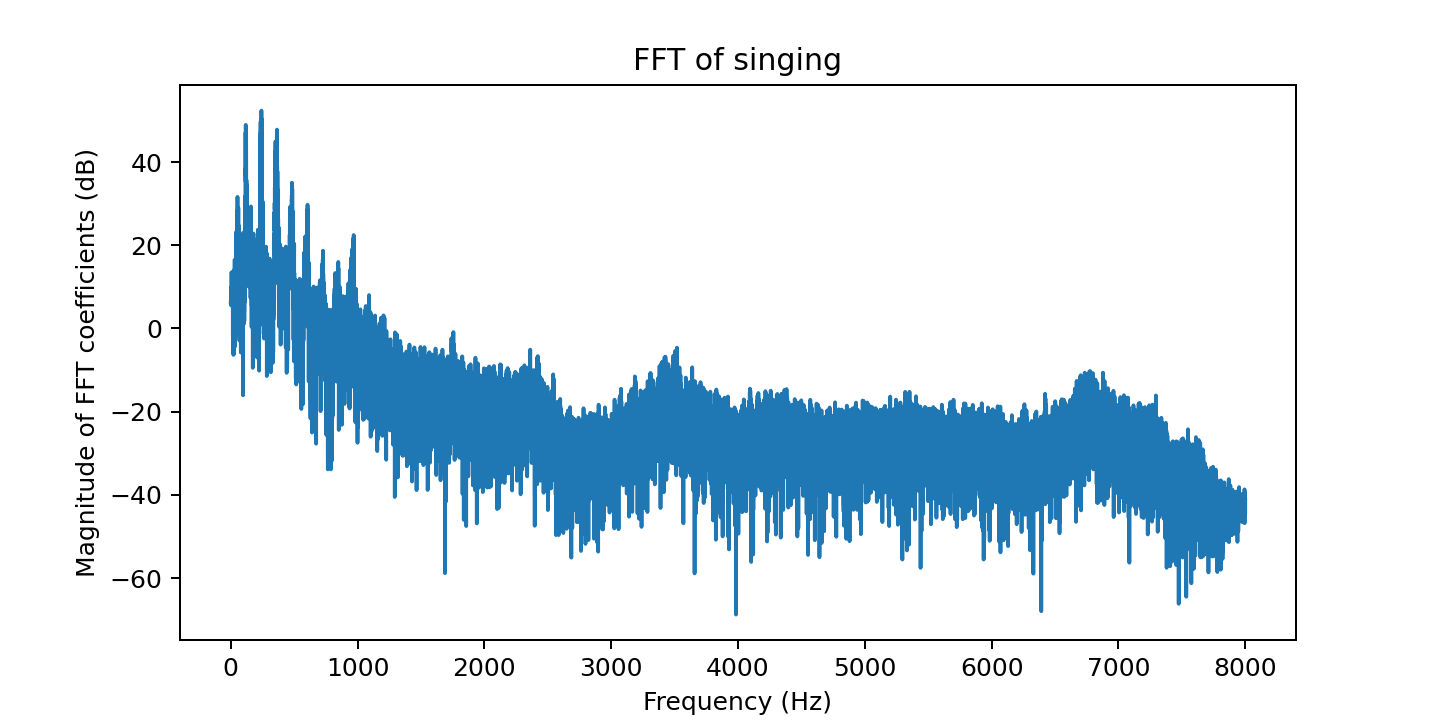

48000
Take a look at how the values are repeated after N/2
[-0.00557024+0.00178825j]
[-0.00728011-0.00175093j]
[-0.00884202+1.56125113e-16j]
[-0.00728011+0.00175093j]
[-0.00557024-0.00178825j]


In [17]:
# Apply the FFT to the signal

N = len(yy)
YY = np.fft.fft(yy,axis=0)  # make sure to specify the axis. zero in this case since the data is along the first axis.
                            # Since yy was an Nx1 vector, python wants to know just where the "N" values are, i.e. in axis = 0
YYss = YY[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

#Set up the frequency vector
df = fs/N  # the frequency bin spacing
freqs = np.arange(0,fs/2+df,df) # first value = DC, last value = fs/2

# Let us plot the Magnitude-Squared

fig, axes = plt.subplots(figsize=(8, 4)) 
axes.plot(freqs,10*np.log10(np.abs(YYss**2)))
# axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_title('FFT of singing')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude of FFT coefficients (dB)')

print(N)

print ("Take a look at how the values are repeated after N/2")
print(YY[N//2 - 2])
print(YY[N//2 - 1])
print(YY[N//2])
print(YY[N//2 + 1])
print(YY[N//2 + 2])


### Spectrograms - Time/Frequency Resolution

Sometimes there is need to not only view the frequency content of a signal, but also how this frequency content changes over time. This can be done using the short time Fourier transform (STFT), whereby the signal is segmented into smaller time frames, and an FFT is performed on each of these time frames. The result can be plotted in what we usually call a **Spectrogram**, where the squared-magnitude of the FFT coefficients is displayed as a colourmap over time and frequency. 

Let's view the spectrogram of our previous signal. One of the parameters we need to choose before hand is the length of these smaller time frames for the signal, i.e. the number of fft points to be used for each of these time segments. Recalling our previous formula for the frequency bin spacing, $df = f_{s}/N_{fft}$, where $N_{fft}$ is the length of the time frame, we can already see a problem of the time-frequency resolution trade-off. As $N_{fft}$ is increased, the frequency resolution is increased, however, the time resolution decreases. Below, change the value of the nfft variable to observe the effect on the spectrogram. What do you think would be an appropriate value?



<IPython.core.display.Javascript object>


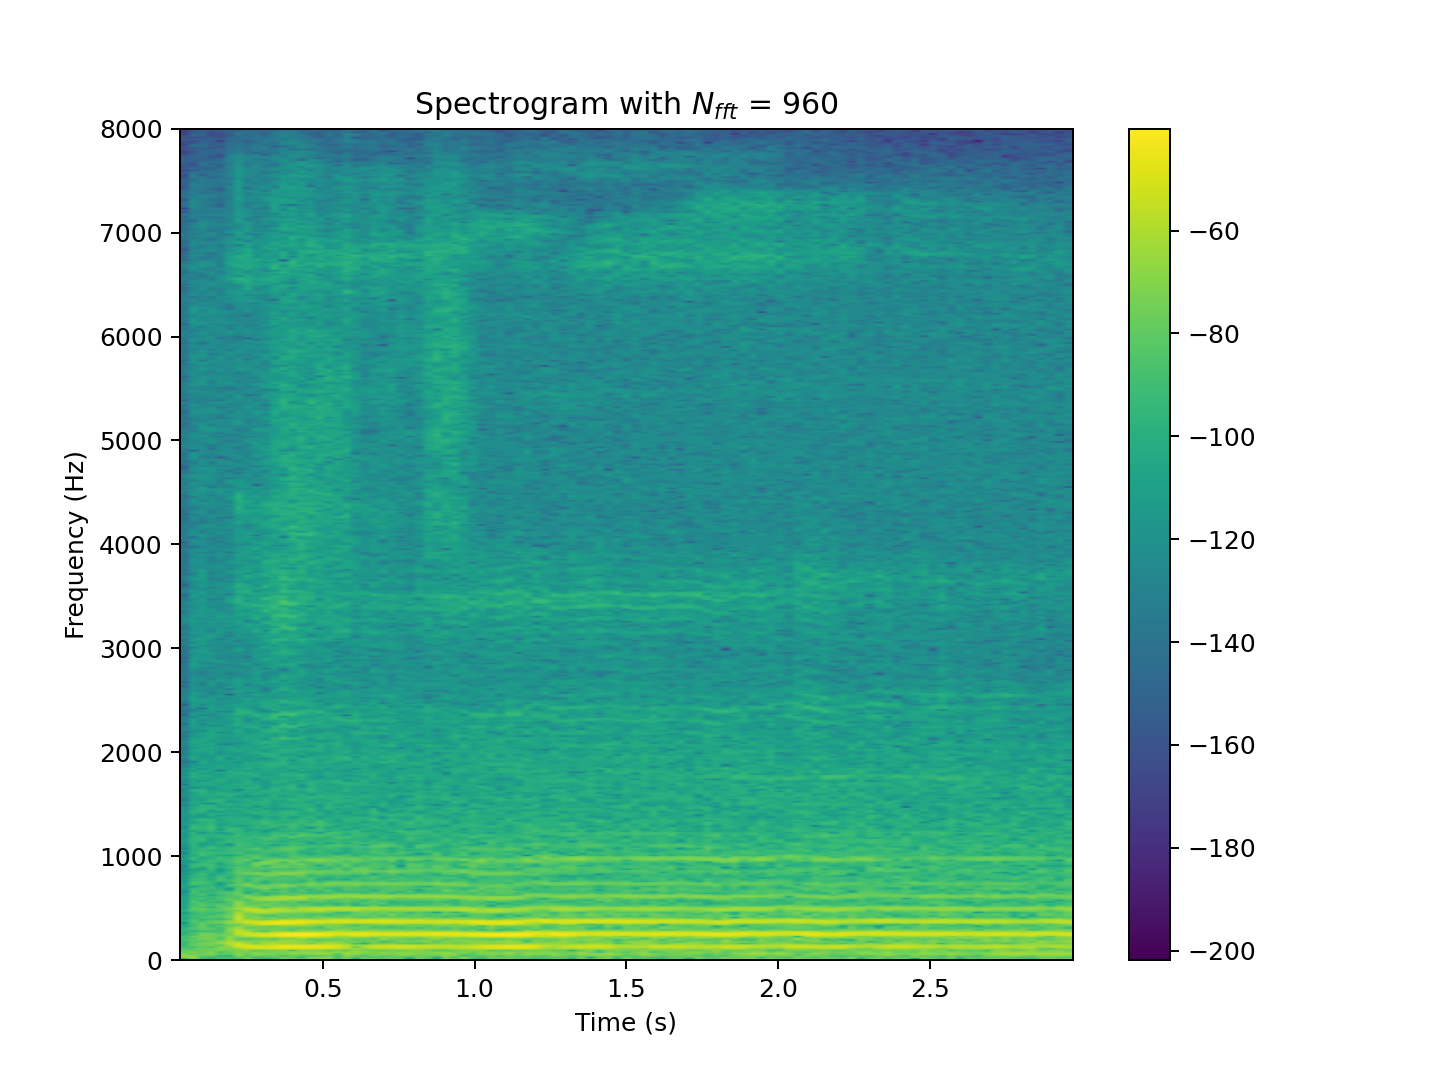

In [22]:
fig, axes = plt.subplots(figsize=(8, 6)) 

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = N//50        # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
# A window is usually applied to the smaller time chunks to reduce any high frequency artifcats. 
# The segments are also usually overlapped to smooth out the temporal variations

f_sg, t_sg, Z_mag = signal.spectrogram(yy[:,0], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"

sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_title('Spectrogram with $N_{fft}$ = '+ str(nfft))
cb = plt.colorbar(sp,ax=[axes],location='right')
